In [1]:
# Import necessary libraries
from roboflow import Roboflow
import zipfile
import os
import json
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from dotenv import load_dotenv

In [2]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
# Initialize COCO object
coco = COCO('Self-Driving-Car-3\export\_annotations.coco.json')

invalid escape sequence '\e'
invalid escape sequence '\e'
invalid escape sequence '\e'


loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


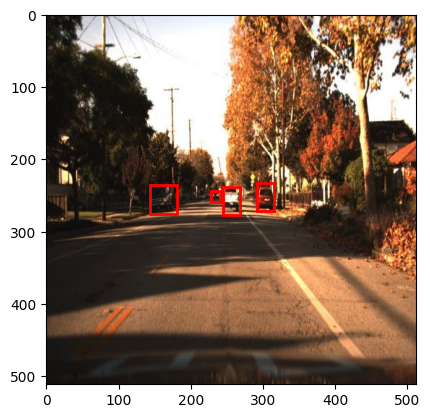

In [4]:
# Get image and annotation IDs
img_id = coco.getImgIds()[30]
img_info = coco.loadImgs(img_id)[0]
img_path = 'Self-Driving-Car-3/export/' + img_info['file_name']

# Load the image
img = Image.open(img_path)

# Load annotations for the image
ann_ids = coco.getAnnIds(imgIds=img_info['id'])
anns = coco.loadAnns(ann_ids)

# Display the image and annotations
plt.imshow(img)
ax = plt.gca()

for ann in anns:
    bbox = ann['bbox']
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)

plt.axis('on')
plt.show()


In [5]:
print(anns)

[{'id': 174, 'image_id': 30, 'category_id': 2, 'bbox': [144, 236, 37, 39.5], 'area': 1461.5, 'segmentation': [], 'iscrowd': 0}, {'id': 175, 'image_id': 30, 'category_id': 2, 'bbox': [228, 244, 14, 14.5], 'area': 203, 'segmentation': [], 'iscrowd': 0}, {'id': 176, 'image_id': 30, 'category_id': 2, 'bbox': [244, 238, 24, 38.5], 'area': 924, 'segmentation': [], 'iscrowd': 0}, {'id': 177, 'image_id': 30, 'category_id': 2, 'bbox': [292, 232, 23.5, 39.5], 'area': 928.25, 'segmentation': [], 'iscrowd': 0}]


In [6]:
# List all categories in the dataset
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]
print("Categories:", category_names)

Categories: ['obstacles', 'biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']


In [7]:
# Count annotations for each category
for category in categories:
    cat_id = category['id']
    annotation_ids = coco.getAnnIds(catIds=cat_id)
    print(f"Category: {category['name']}, Number of annotations: {len(annotation_ids)}")


Category: obstacles, Number of annotations: 0
Category: biker, Number of annotations: 3704
Category: car, Number of annotations: 127873
Category: pedestrian, Number of annotations: 21491
Category: trafficLight, Number of annotations: 5101
Category: trafficLight-Green, Number of annotations: 10838
Category: trafficLight-GreenLeft, Number of annotations: 614
Category: trafficLight-Red, Number of annotations: 13673
Category: trafficLight-RedLeft, Number of annotations: 3482
Category: trafficLight-Yellow, Number of annotations: 541
Category: trafficLight-YellowLeft, Number of annotations: 28
Category: truck, Number of annotations: 7194


In [8]:
# Preprocess images and annotations
data_dir = "Self-Driving-Car-3"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
from torchvision.transforms import functional as F                   

In [10]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import json

class SelfDrivingCarDataset(Dataset):
    def __init__(self, data_dir, annotations_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)
        self.image_info = {img['id']: img for img in self.annotations['images']}
        self.annotation_info = self.annotations['annotations']
        self.image_ids = list(self.image_info.keys())
        
        # Define categories
        self.categories = [
            'obstacles', 'biker', 'car', 'pedestrian', 'trafficLight', 
            'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 
            'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck'
        ]
        # Map category_id to index
        self.category_to_idx = {i+1: idx for idx, i in enumerate(range(len(self.categories)))}

    def resize_image_and_boxes(self, image, boxes, size):
        orig_width, orig_height = image.size
        new_width, new_height = size
        image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

        resized_boxes = []
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            x_min = int(x_min * new_width / orig_width)
            y_min = int(y_min * new_height / orig_height)
            x_max = int(x_max * new_width / orig_width)
            y_max = int(y_max * new_height / orig_height)
            resized_boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])

        return image, resized_boxes

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.image_info[img_id]
        img_path = os.path.join(self.data_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")
        
        boxes = []
        labels = []
        categories = []
        
        for ann in self.annotation_info:
            if ann['image_id'] == img_id:
                x_min, y_min, width, height = ann['bbox']
                x_max = x_min + width
                y_max = y_min + height
                boxes.append([x_min, y_min, x_max, y_max])
                category_id = ann['category_id']
                labels.append(category_id)
                categories.append(self.category_to_idx[category_id])

        if self.transform:
            image, boxes = self.resize_image_and_boxes(image, boxes, (128, 128))
            image = self.transform(image)
        
        return image, boxes, labels, categories



In [11]:
# Define paths
data_dir = "Self-Driving-Car-3/export"
annotations_file = os.path.join(data_dir, "_annotations.coco.json") 

# Load annotations
with open(annotations_file, 'r') as f:
    annotations = json.load(f)

In [12]:
def custom_collate_fn(batch):
    images, boxes, labels, categories = zip(*batch)

    # Clone and detach images to avoid the warning
    images = torch.stack([img.clone().detach() for img in images])

    # Boxes, labels, and categories can be kept as lists of tensors
    boxes = [torch.tensor(b).clone().detach() for b in boxes]
    labels = [torch.tensor(l).clone().detach() for l in labels]
    categories = [torch.tensor(c).clone().detach() for c in categories]

    return images, boxes, labels, categories


In [13]:
def split_dataset(dataset, test_size=0.2, subset_ratio=1.0):
    # Split into train and test indices
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size)
    
    # Apply subset ratio
    train_subset_size = int(len(train_indices) * subset_ratio)
    test_subset_size = int(len(test_indices) * subset_ratio)
    
    train_indices = np.random.choice(train_indices, train_subset_size, replace=False)
    test_indices = np.random.choice(test_indices, test_subset_size, replace=False)
    
    # Create subsets
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)
    
    return train_subset, test_subset

In [14]:
# Create dataset
dataset = SelfDrivingCarDataset(data_dir, annotations_file, transform)

# Split dataset into training and testing subsets with a smaller subset ratio
train_dataset, test_dataset = split_dataset(dataset, test_size=0.2, subset_ratio=0.1) 

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)

In [15]:
# Get a sample from the dataset
image, boxes, labels, categories = train_dataset[0]
print(type(image))  # Check the type of the image

<class 'torch.Tensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].


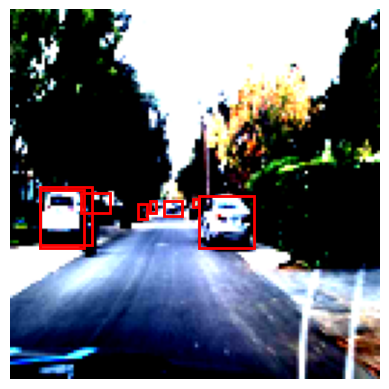

In [16]:
def visualize_data(image, boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for displaying

    for box in boxes:
        x, y, w, h = box
        rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Get a sample from the dataset
image, boxes, labels, categories = train_dataset[2]
visualize_data(image, boxes)

In [17]:
class DrivingEnv:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.data_iter = iter(dataloader)  # Create an iterator over the dataloader
        self.current_state = None

    def reset(self):
        self.data_iter = iter(self.dataloader)  # Reset the iterator
        self.current_state = next(self.data_iter)  # Get the first batch
        return self.current_state

    def step(self, action):
        try:
            self.current_state = next(self.data_iter)  # Get the next batch
            done = False
        except StopIteration:
            done = True  # No more data available

        reward = 0
        if not done:
            # Define a simple reward mechanism based on the action
            if action == "stop" and self._is_danger_ahead(self.current_state):
                reward = 1  # Positive reward for stopping in danger
            elif action == "go" and not self._is_danger_ahead(self.current_state):
                reward = 1  # Positive reward for moving safely
            else:
                reward = -1  # Negative reward for unsafe actions

        return self.current_state, reward, done, {}

    def _is_danger_ahead(self, state):
        image, boxes, labels, categories = state  # Unpack the state to include categories
        for box, label, category in zip(boxes, labels, categories):
            # Check if a dangerous category is close in front
            if category in ['car', 'pedestrian', 'trafficLight-Red', 'trafficLight-RedLeft','trafficLight-Yellow' ] and box[1] < 300:
                return True
        return False




In [18]:
# Assuming dataset is already prepared and loaded
env = DrivingEnv(train_dataloader)

# Reset the environment to start
state = env.reset()

In [19]:
# Take an action
next_state, reward, done, _ = env.step("go")

# Print the results
print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)

Next State: (tensor([[[[-0.4397, -0.5082, -0.6109,  ...,  1.5468,  1.5468,  1.5468],
          [-0.4568, -0.4226, -0.5767,  ...,  1.5982,  1.6324,  1.6324],
          [-0.4397, -0.4226, -0.3883,  ...,  1.7009,  1.7009,  1.7352],
          ...,
          [-1.8439, -1.8268, -1.8439,  ..., -1.8953, -1.8953, -1.8953],
          [-1.8439, -1.8439, -1.8782,  ..., -1.8953, -1.8953, -1.8953],
          [-1.8097, -1.8097, -1.8439,  ..., -1.8953, -1.8953, -1.8953]],

         [[-0.3025, -0.3725, -0.4776,  ...,  1.6408,  1.6408,  1.6408],
          [-0.3375, -0.2850, -0.4426,  ...,  1.6758,  1.7108,  1.7108],
          [-0.3200, -0.3025, -0.2500,  ...,  1.7283,  1.7283,  1.7633],
          ...,
          [-1.7731, -1.7556, -1.7731,  ..., -1.8081, -1.8081, -1.8081],
          [-1.7731, -1.7731, -1.8081,  ..., -1.8081, -1.8081, -1.8081],
          [-1.7381, -1.7381, -1.7731,  ..., -1.8081, -1.8081, -1.8081]],

         [[ 0.0256, -0.0790, -0.2010,  ...,  1.8383,  1.8383,  1.8383],
          [ 0.025

In [20]:
# Assuming the first element is the image tensor
image_tensor = state[0]

# Print the shape of the image tensor
print(f"Image tensor shape: {image_tensor.shape}")

Image tensor shape: torch.Size([2, 3, 128, 128])


In [21]:
# Flatten the image tensor to match the expected input of the DQN
flattened_image_tensor = torch.flatten(image_tensor, start_dim=1)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import torch.nn.functional as F

In [23]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self.feature_size(input_shape), 512)
        self.fc2 = nn.Linear(512, num_actions)

    def feature_size(self, input_shape):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *input_shape)))).view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [24]:
input_shape = (3, 128, 128)  # Adjust based on your image size and channels
num_actions = 2  # Number of actions: go and stop
model = DQN(input_shape, num_actions)

In [25]:
# Pass the flattened image tensor to the model
#output = model(flattened_image_tensor)

# Print the output to see the model's prediction
#print(f"Model output: {output}")

In [26]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration-exploitation trade-off
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 32
memory_size = 5000


In [27]:
# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [28]:
# Replay buffer
memory = deque(maxlen=memory_size)

In [31]:
from collections import deque
import random
import math

optimizer = optim.Adam(model.parameters(), lr=0.0001)
memory = deque(maxlen=10000)
batch_size = 32
gamma = 0.99  # Discount factor

def select_action(state, epsilon):
    state = state.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    if random.random() > epsilon:
        with torch.no_grad():
            q_values = model(state)
            return q_values.max(1)[1].item()  # Returns the index of the maximum Q-value
    else:
        return random.randrange(num_actions)

def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = random.sample(memory, batch_size)
    batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

    # Convert to tensors and move to device
    batch_state = torch.cat([s.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for s in batch_state])
    batch_action = torch.tensor(batch_action, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    batch_reward = torch.tensor(batch_reward, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    batch_next_state = torch.cat([s.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for s in batch_next_state])
    batch_done = torch.tensor(batch_done, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    current_q_values = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
    next_q_values = model(batch_next_state).max(1)[0]
    expected_q_values = batch_reward + (gamma * next_q_values) * (1 - batch_done)

    loss = F.mse_loss(current_q_values, expected_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

num_episodes = 100
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 500

for episode in range(num_episodes):
    state, _, _, _ = env.reset()
    state = state[0].to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).unsqueeze(0)
    total_reward = 0

    for t in range(2000):
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * episode / epsilon_decay)
        action = select_action(state, epsilon)

        next_state, reward, done, _ = env.step("go" if action == 1 else "stop")
        next_state = next_state[0].to(torch.device("cuda" if torch.cuda.is_available() else "cpu")).unsqueeze(0)

        memory.append((state, action, reward, next_state, done))

        state = next_state
        total_reward += reward

        optimize_model()

        if done:
            break

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

RuntimeError: Tensors must have same number of dimensions: got 5 and 4

In [35]:
print("Sample memory content:")
for i in range(5):
    print(memory[i])

Sample memory content:
(tensor([[[[ 2.0777,  2.0263,  2.1290,  ..., -1.8439, -1.8268, -1.8097],
          [ 2.2147,  2.2318,  2.2318,  ..., -1.7925, -1.8268, -1.7754],
          [ 2.2489,  2.2489,  2.2489,  ..., -1.8268, -1.7925, -1.8097],
          ...,
          [-1.6555, -1.6555, -1.6898,  ..., -1.1247, -1.1418, -1.1932],
          [-1.7069, -1.6727, -1.6898,  ..., -1.1418, -1.1418, -1.1760],
          [-1.7240, -1.7240, -1.7412,  ..., -1.0733, -1.1418, -1.1589]],

         [[ 2.3936,  2.3585,  2.4286,  ..., -1.7556, -1.7381, -1.7206],
          [ 2.3936,  2.4111,  2.4286,  ..., -1.7031, -1.7381, -1.6856],
          [ 2.4111,  2.4111,  2.4111,  ..., -1.7381, -1.7031, -1.7206],
          ...,
          [-1.5455, -1.5455, -1.5805,  ..., -0.9853, -0.9503, -0.9328],
          [-1.5980, -1.5630, -1.5805,  ..., -1.0028, -0.9503, -0.9328],
          [-1.6155, -1.6155, -1.6331,  ..., -0.9153, -0.9503, -0.9328]],

         [[ 2.5703,  2.5180,  2.6051,  ..., -1.5604, -1.5430, -1.5256],
      